# Project 01 - Classification

-   Date: Jan 29th 12pm
-   Group Members: 
  - Guanyu Qian (UID: 606076335)
  - Hanyi Duan (UID: 806073864)
  - Yifan Zhong (UID: 705507868)




# Prework



In [1]:
import math
import random
import re
from shutil import rmtree
from string import punctuation
from tempfile import mkdtemp

import nltk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn import metrics, svm
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

plt.rcParams["figure.figsize"] = (10,5) # adjust fig size *for all figs*

In [ ]:
nltk.download('all')

In [3]:
wnl = nltk.wordnet.WordNetLemmatizer()

ps = nltk.stem.PorterStemmer()

stop_words_skt = text.ENGLISH_STOP_WORDS

stop_words_en = stopwords.words('english')

combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

In [4]:
# clean function is adopted from the Porject-1 maual. The fuction efficiency is improved by the commented lines.

def clean(text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  texter = re.sub(r'\d+', '', texter) # exclude numbers
  texter = re.sub('[^a-zA-Z0-9\n]', ' ', texter) # Replace characters other than A-Za-z0-9 and decimal values with space 
  texter = re.sub('\s+',' ', texter) #  # Eliminate duplicate whitespaces using wildcards
  texter = texter.lower() # convert the text to lower case
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
      texter = ""
  return texter

# penn2morphy function is adopted form Project1-Discussion_Material_Part3.ipynb

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

# lemmatize_sent function is adopted form Project1-Discussion_Material_Part3.ipynb

def lemmatize_sent(list_word): 
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

# stem_rmv_punc function is adopted form Project1-Discussion_Material_Part3.ipynb

def stem_rmv_punc(doc):
    # this should have been at the sentence-level because the pos-tag performs best at sentence-level
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

# with help from one of the TAs during the office hour

def stemming(text):
    text_stemmed = []
    for t in text:
        words = [ps.stem(word) for word in nltk.word_tokenize(t)]
        sentence = ' '.join(words)
        text_stemmed.append(sentence)
    return text_stemmed

def lemmatize(text):
    text_lemmatized = []
    for t in text:
        words = [wnl.lemmatize(word, pos=penn2morphy(tag))
                 for word, tag in pos_tag(nltk.word_tokenize(t))]
        sentence = ' '.join(words)
        text_lemmatized.append(sentence) 
    return text_lemmatized

In [5]:
path = "proj1_classification.csv"
data = pd.read_csv(path)

# Getting familiar with the dataset

#### **Question 1**
1. **Overview**: There are a total of 3150 rows and 8 cloumns presented in the dataset.
2. **Histograms**: Please refer to the graphs down below.
3. **Interpret Plots**: Please refer to the graphs down below.
---

In [7]:
display(data.head(3))
print("There are", data.shape[0], "rows and", data.shape[1], "columns presented in the dataset.")

In [ ]:
# Get alpha-numeric characters count
charCounts = []
for i in range(data.shape[0]):
    # filter out alpha-numeric char
    cleanedText = re.sub('[\W_]+', '', data.iloc[i]["full_text"])
    cnt = len(cleanedText)
    charCounts.append(cnt)

plt.hist(charCounts, bins=100)
plt.title('Alpha-numeric Character Counts')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.show()

**Interpretation of the plot**
- Most articles have alpha-numeric character count within the range of 10000 *characters*.
- There are still some articles fall in the range between 10000 and 30000 characters.
- Only limited amount of articles have character count above 30000.

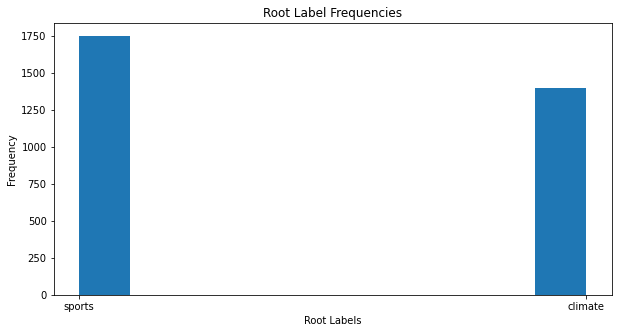

In [ ]:
data_root_label = data["root_label"]

plt.hist(data_root_label)
plt.title('Root Label Frequencies')
plt.xlabel('Root Labels')
plt.ylabel('Frequency')

plt.show()

**Interpretation of the plot**
- More articles are related to sports than climate.
- There are around 1750 articles about sports and 1450 articles about climate.

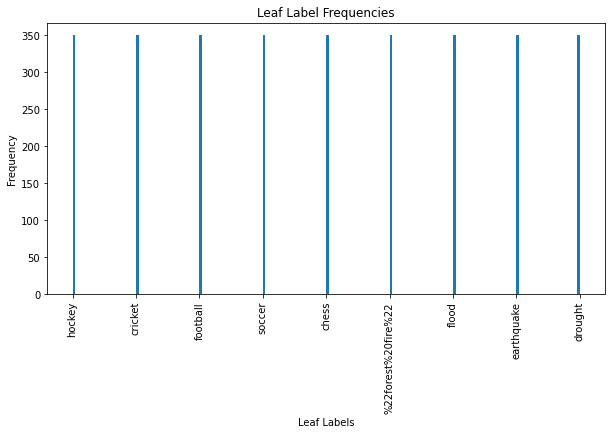

In [ ]:
data_leaf_label = data["leaf_label"]

plt.hist(data_leaf_label, bins=200)
plt.title('Leaf Label Frequencies')
plt.xlabel('Leaf Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

plt.show()

**Interpretation of the plot**
- There are equal amounts of articles with different leaf lables present in the dataset.
- The amount of articles with different leaf labels are all 350

# Binary Classification

#### **Question 2**
- There are 2520 training samples.
- There are 630 testing samples.
---

- Splitting the entire dataset into training and testing data

In [ ]:
np.random.seed(42)
random.seed(42)

In [ ]:
train, test = train_test_split(data[['full_text', 'root_label']], test_size=0.2)
print("There are", train.shape[0], "training samples.")
print("There are", test.shape[0], "testing samples.")

There are 2520 training samples.
There are 630 testing samples.


* Feature Extraction

#### **Question 3**
1. **Lemmatization vs. Stemming**
  - Pros
    - Lemmatization has higher accuracy since it involves morphological analysis while stemming simply cuts off the affixes of the words.
    - Lemmatization will not change the meaning of the word.
  - Cons:
    - Lemmatization is harder to implement and slower to run since it is more complex than stemming. 
    - Lemmatization requires a large amount of prior knowledge, a  complete vocabulary, to work with, while stemming only needs a small amount of hard-coded rules.
  - These process will reduce the size of the vocabulary since they can reduce the inflectional or derivationally related forms of words to a common form. 

2. **min_df & tfidf matrix**
  - When `min_df=3`, the tfidf matrix has 13466 columns. When `min_df=5`, the tfidf matrix has 9377 columns. When `min_df=7`, the matrix has 7308 columns (We only keep min_df=3 here). Increasing min_df will reduce the column number of the tfidf matrix since more words will be filtered out and the vocabulary will reduce.

3. **Relative Orders of Data Cleaning and Lemmatization**
  - Lemmatization is performed after the stop words and numbers are being removed, and before the punctuations are being removed.
4. **The Shape of TF-IDF-processed Matrice**
  - The shape of TF-IDF-processed train matrix is (2520 x 13465)
  - The shape of TF-IDF-processed test matrix is (630 x 13465)
  - Note that different results of data splitting may result in differences in the dimentionality of the matrices
---

In [ ]:
train = train.applymap(clean)
test = test.applymap(clean)

wnl = nltk.wordnet.WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

vectorizer = CountVectorizer(min_df=3, stop_words='english',analyzer=stem_rmv_punc)
X_train = vectorizer.fit_transform(train['full_text'])
X_test = vectorizer.transform(test['full_text'])
print(X_train.shape)
print(X_test.shape)


(2520, 13732)
(630, 13732)


In [ ]:
# IT_IDF transform
tfidf = TfidfTransformer()

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)


(2520, 13732)
(630, 13732)


#3. Dimensionality Reduction


* Latent Semantic Indexing (LSI)

MSE for SVD transfermation is : 4.911548907872161e-05


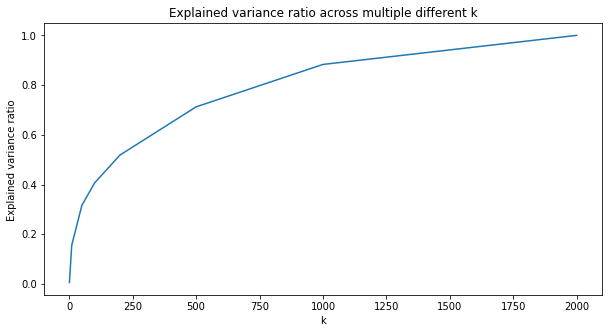

In [ ]:
# SVD transform
k=[1,10, 50, 100, 200, 500, 1000, 2000]

variance_ratio_sum=[]
for item in k:
    svd = TruncatedSVD(n_components=item, n_iter=7, random_state=42)
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)
    variance_ratio=svd.explained_variance_ratio_.sum()
    variance_ratio_sum.append(variance_ratio)
plt.plot(k,variance_ratio_sum)

plt.title('Explained variance ratio across multiple different k')
plt.xlabel('k')
plt.ylabel('Explained variance ratio ')


#chose k=50
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)


X_train_reconstructed_tfidf_svd = svd.inverse_transform(X_train_svd)

mse_svd = mean_squared_error(X_train_tfidf.toarray(), X_train_reconstructed_tfidf_svd)

print("MSE for SVD transfermation is :", mse_svd )

* Non-negative Matrix Factorization (NMF)



In [ ]:
nmf = NMF(n_components=50, init = 'random', random_state=42) 

W_train_nmf = nmf.fit_transform(X_train_tfidf)
W_test_nmf = nmf.transform(X_test_tfidf)
H=nmf.components_

#WH_train=np.dot(W_train_nmf, H)

X_train_reconstructed_tfidf_nmf = nmf.inverse_transform(W_train_nmf)

mse_nmf = mean_squared_error(X_train_tfidf.toarray(), X_train_reconstructed_tfidf_nmf)

print("MSE for NMF transfermation is :", mse_nmf )

MSE for NMF transfermation is : 4.989949441349569e-05


#### **Question 4**
- Plot’s concavity
  - The plot looks like an inverse exponential curve, increasing rapidly at first and then converging to a certain value. The plot’s concavity suggests that the explained variance ratio will be saturated as k increases. 

- Residual MSE
  - MSE for NMF is larger than the MSE for LSI. This reason is probably that the NMF is a more approximation-like methodology for dimension reduction, as it is indicated in the text that X is approximately equal to W*H. Furthermore, NMF has limited accuracy when it comes to reducing dense matrices like TF-IDF in this case. Therefore, it is expected that the LSI method to have a smaller MSE.
---

#4. Classification Algorithms

In [ ]:
X_train_binrary_label= train["root_label"]
X_test_binrary_label = test["root_label"]

#convert categorical label to 0 and 1.
X_train_binrary_label[X_train_binrary_label  == 'sports'] = 1
X_train_binrary_label[X_train_binrary_label  == 'climate'] = 0
X_train_binrary_label= X_train_binrary_label.astype(int)

X_test_binrary_label[X_test_binrary_label  == 'sports'] = 1
X_test_binrary_label[X_test_binrary_label  == 'climate'] = 0
X_test_binrary_label = X_test_binrary_label.astype(int)


svm_1000 = SVC(C=1000, kernel='linear', probability=True)
svm_00001 = SVC(C=0.0001, kernel='linear', probability=True)

pipeline_hard_margin = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=50, n_iter=7, random_state=42)),
    ('svm', svm_1000),
])

pipeline_soft_margin = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=50, n_iter=7, random_state=42)),
    ('svm', svm_00001),
])



In [ ]:
# ROC plot function 
# plot_roc function is adopted form Project1-Discussion_Material_Part2.ipynb

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)


# fit_predict_and_plot_roc function is adopted form Project1-Discussion_Material_Part2.ipynb

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):

    pipe.fit(train_data, train_label)

    prob_score = pipe.predict_proba(test_data)

    fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
    return pipe



Confusion matrix is :
  [[257   6]
 [ 17 350]]
Accuracy is :  0.9634920634920635
Recall is :  0.9536784741144414
Precision is :  0.9831460674157303
F-1 socre is :  0.9681881051175657


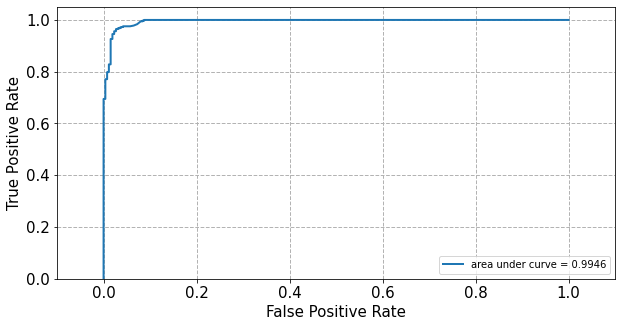

In [ ]:
# hard margin ROC curve gamma=1000
fit_predict_and_plot_roc(pipeline_hard_margin, X_train_tfidf, X_train_binrary_label, X_test_tfidf, X_test_binrary_label)

#confusion matrix

confusion_matrix = metrics.confusion_matrix(X_test_binrary_label, svm_1000.predict(X_test_svd))


#accuracy

accuracy=metrics.accuracy_score(X_test_binrary_label, svm_1000.predict(X_test_svd))

#recall
recall=metrics.recall_score(X_test_binrary_label, svm_1000.predict(X_test_svd))

#precision
precision=metrics.precision_score(X_test_binrary_label, svm_1000.predict(X_test_svd))

#f1 score
f_1=metrics.f1_score(X_test_binrary_label, svm_1000.predict(X_test_svd))


print("Confusion matrix is :\n ", confusion_matrix)

print("Accuracy is : ", accuracy)

print("Recall is : ", recall)

print("Precision is : ", precision)

print("F-1 socre is : ", f_1)



Confusion matrix is :
  [[  0 263]
 [  0 367]]
Accuracy is :  0.5825396825396826
Recall is :  1.0
Precision is :  0.5825396825396826
F-1 socre is :  0.7362086258776329


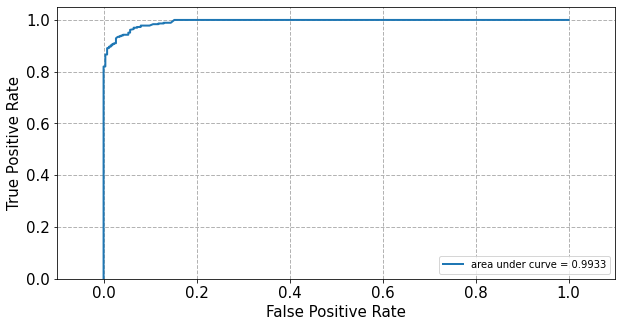

In [ ]:
# soft margin ROC curve gamma=0.0001

fit_predict_and_plot_roc(pipeline_soft_margin, X_train_tfidf, X_train_binrary_label, X_test_tfidf, X_test_binrary_label)

#confusion matrix

confusion_matrix = metrics.confusion_matrix(X_test_binrary_label, svm_00001.predict(X_test_svd))

#accuracy

accuracy=metrics.accuracy_score(X_test_binrary_label, svm_00001.predict(X_test_svd))

#recall
recall=metrics.recall_score(X_test_binrary_label, svm_00001.predict(X_test_svd))

#precision
precision=metrics.precision_score(X_test_binrary_label, svm_00001.predict(X_test_svd))

#f1 score
f_1=metrics.f1_score(X_test_binrary_label, svm_00001.predict(X_test_svd))


print("Confusion matrix is :\n ", confusion_matrix)

print("Accuracy is : ", accuracy)

print("Recall is : ", recall)

print("Precision is : ", precision)

print("F-1 socre is : ", f_1)


Confusion matrix is :
  [[258   5]
 [ 19 348]]
Accuracy is :  0.9619047619047619
Recall is :  0.9482288828337875
Precision is :  0.9858356940509915
F-1 socre is :  0.9666666666666668


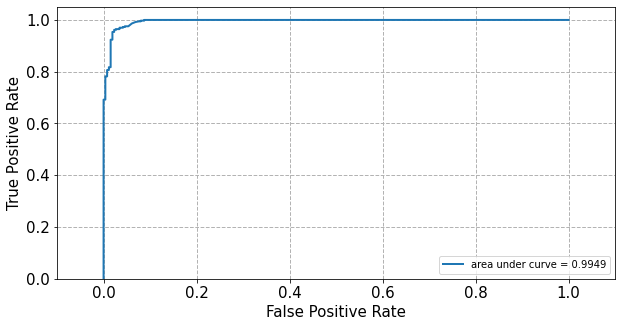

In [ ]:
# gamma 100000

svm_100000 = SVC(C=100000, kernel='linear', probability=True)

pipeline_gamma_100000 = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=50, n_iter=7, random_state=42)),
    ('svm', svm_100000),
])


# ROC curve gamma=100000

fit_predict_and_plot_roc(pipeline_gamma_100000, X_train_tfidf, X_train_binrary_label, X_test_tfidf, X_test_binrary_label)

#confusion matrix

confusion_matrix = metrics.confusion_matrix(X_test_binrary_label, svm_100000.predict(X_test_svd))

#accuracy

accuracy=metrics.accuracy_score(X_test_binrary_label, svm_100000.predict(X_test_svd))

#recall
recall=metrics.recall_score(X_test_binrary_label, svm_100000.predict(X_test_svd))

#precision
precision=metrics.precision_score(X_test_binrary_label, svm_100000.predict(X_test_svd))

#f1 score
f_1=metrics.f1_score(X_test_binrary_label, svm_100000.predict(X_test_svd))


print("Confusion matrix is :\n ", confusion_matrix)

print("Accuracy is : ", accuracy)

print("Recall is : ", recall)

print("Precision is : ", precision)

print("F-1 socre is : ", f_1)


In [ ]:
c=[10**-3, 10**-2, 10**-1, 10, 100, 1000, 10000, 100000, 100000]


validation_accuracy=[]

for i in c:
  svm_opt = SVC(C=i)
  scores = cross_val_score(svm_opt, X_train_svd, X_train_binrary_label, cv=5)
  scores = scores.mean()
  validation_accuracy.append(scores)

print(validation_accuracy)


[0.5488095238095239, 0.7861111111111111, 0.9412698412698413, 0.9587301587301587, 0.9571428571428571, 0.9503968253968255, 0.9503968253968255, 0.9503968253968255, 0.9503968253968255]


The optimal gamma is : 10
Confusion matrix is :
  [[256   7]
 [ 17 350]]
Accuracy is :  0.9619047619047619
Recall is :  0.9536784741144414
Precision is :  0.9803921568627451
F-1 socre is :  0.9668508287292817


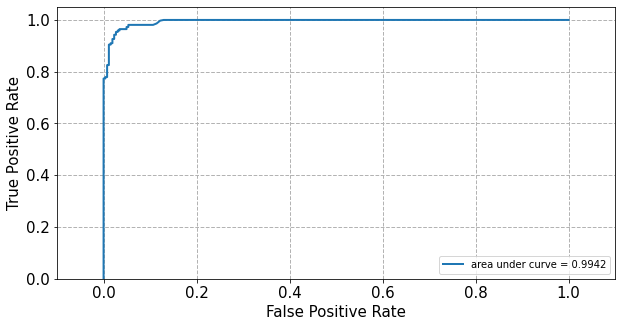

In [ ]:
# Find the optimal gamma

for i in range (9):
  if validation_accuracy[i] == max(validation_accuracy):
    print("The optimal gamma is :", c[i])


# optimal gamma = 10

svm_10 = SVC(C=10, kernel='linear', probability=True)

pipeline_gamma_10 = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=50, n_iter=7, random_state=42)),
    ('svm', svm_10),
])



# ROC curve gamma = 10

fit_predict_and_plot_roc(pipeline_gamma_10, X_train_tfidf, X_train_binrary_label, X_test_tfidf, X_test_binrary_label)

#confusion matrix

confusion_matrix = metrics.confusion_matrix(X_test_binrary_label, svm_10.predict(X_test_svd))

#accuracy

accuracy=metrics.accuracy_score(X_test_binrary_label, svm_10.predict(X_test_svd))

#recall
recall=metrics.recall_score(X_test_binrary_label, svm_10.predict(X_test_svd))

#precision
precision=metrics.precision_score(X_test_binrary_label, svm_10.predict(X_test_svd))

#f1 score
f_1=metrics.f1_score(X_test_binrary_label, svm_10.predict(X_test_svd))

print("Confusion matrix is :\n ", confusion_matrix)

print("Accuracy is : ", accuracy)

print("Recall is : ", recall)

print("Precision is : ", precision)

print("F-1 socre is : ", f_1)


#### **Question 5**
  - Hard vs Soft Margin:
    - Hard-margin SVM performs better because it has a much higher accuracy score than soft-margin SVM. For $\gamma$ = 10000, the accuracy score slightly drops, which may suggest that the model overfits the data.

  - Soft Margin Issues:
    - The confusion matrix shows zero value in the true-positive and false-negative sections. This is because the soft margin failed to identify any true-positive and false-negative results. For example, when the model predicts a negative result, the actual result is never negative or vice versa. This indicates that the model does not fit the data well. 

  - Optimal $\gamma$ value 
    - By 5- fold cross-validation, it is found that the optimal $\gamma$ is 10. The accuracy, recall, precision, and F-1 scores are shown below:
      - Accuracy is :  0.9619047619047619
      - Recall is :  0.9536784741144414
     - Precision is :  0.9803921568627451
     - F-1 socre is :  0.9668508287292817 
---

* Logistic Regression:

Confusion matrix is :
  [[257   6]
 [ 18 349]]
Accuracy is :  0.9619047619047619
Recall is :  0.9509536784741145
Precision is :  0.9830985915492958
F-1 socre is :  0.9667590027700832


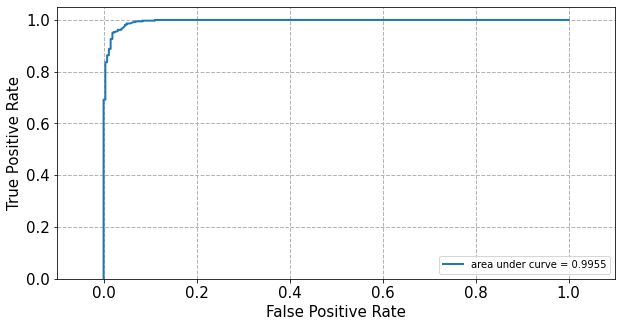

In [ ]:
# log regression
# No regularization

log_reg_0 = LogisticRegression(penalty="none", max_iter=100000) #logistic classifier without regularization by setting penalty = none

pipeline_log_reg_0 = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=50, n_iter=7, random_state=42)),
    ('log_reg_0', log_reg_0),
])


# ROC curve w/o regularization

fit_predict_and_plot_roc(pipeline_log_reg_0, X_train_tfidf, X_train_binrary_label, X_test_tfidf, X_test_binrary_label)

#confusion matrix

confusion_matrix = metrics.confusion_matrix(X_test_binrary_label, log_reg_0.predict(X_test_svd))

#accuracy

accuracy=metrics.accuracy_score(X_test_binrary_label, log_reg_0.predict(X_test_svd))

#recall
recall=metrics.recall_score(X_test_binrary_label, log_reg_0.predict(X_test_svd))

#precision
precision=metrics.precision_score(X_test_binrary_label, log_reg_0.predict(X_test_svd))

#f1 score
f_1=metrics.f1_score(X_test_binrary_label, log_reg_0.predict(X_test_svd))


print("Confusion matrix is :\n ", confusion_matrix)

print("Accuracy is : ", accuracy)

print("Recall is : ", recall)

print("Precision is : ", precision)

print("F-1 socre is : ", f_1)



In [ ]:

log_reg_L = LogisticRegression(max_iter=100000)


grid_L1 = {'C': [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10, 100, 1000, 10000, 100000], 
           'penalty': ['l1'],
           'solver': ['liblinear']
           }

grid_L2 = {'C': [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10, 100, 1000, 10000, 100000], 
           'penalty': ['l2'],
           'solver': ['liblinear']
           }


grid_search_L1 = GridSearchCV(log_reg_L, grid_L1, cv=5, scoring= 'accuracy')
grid_search_L1.fit(X_train_svd, X_train_binrary_label)


grid_search_L2 = GridSearchCV(log_reg_L, grid_L2, cv=5, scoring= 'accuracy')
grid_search_L2.fit(X_train_svd, X_train_binrary_label)


L1_opt = grid_search_L1.best_params_['C']
L2_opt = grid_search_L2.best_params_['C']

print("optimal regularization strength for L1 is :", L1_opt )
print("optimal regularization strength for L2 is :", L2_opt )



optimal regularization strength for L1 is : 1000
optimal regularization strength for L2 is : 100000


In [ ]:
log_reg_L1_opt = LogisticRegression(C= 1000, penalty = 'l1', solver='liblinear', max_iter=100000)

log_reg_L2_opt = LogisticRegression(C= 100000, penalty = 'l2', solver='liblinear', max_iter=100000)


log_reg_0.fit(X_train_svd, X_train_binrary_label)

log_reg_L1_opt.fit(X_train_svd, X_train_binrary_label)

log_reg_L2_opt.fit(X_train_svd, X_train_binrary_label)



#w/o regularization
#confusion matrix

confusion_matrix = metrics.confusion_matrix(X_test_binrary_label, log_reg_0.predict(X_test_svd))

#accuracy

accuracy=metrics.accuracy_score(X_test_binrary_label, log_reg_0.predict(X_test_svd))

#recall
recall=metrics.recall_score(X_test_binrary_label, log_reg_0.predict(X_test_svd))

#precision
precision=metrics.precision_score(X_test_binrary_label, log_reg_0.predict(X_test_svd))

#f1 score
f_1=metrics.f1_score(X_test_binrary_label, log_reg_0.predict(X_test_svd))

print("w/o regularization :")
print("Confusion matrix is :\n ", confusion_matrix)

print("Accuracy is : ", accuracy)

print("Recall is : ", recall)

print("Precision is : ", precision)

print("F-1 socre is : ", f_1)



print("\n")


#L1
#confusion matrix

confusion_matrix_1= metrics.confusion_matrix(X_test_binrary_label, log_reg_L1_opt.predict(X_test_svd))

#accuracy

accuracy_1=metrics.accuracy_score(X_test_binrary_label, log_reg_L1_opt.predict(X_test_svd))

#recall
recall_1=metrics.recall_score(X_test_binrary_label, log_reg_L1_opt.predict(X_test_svd))

#precision
precision_1=metrics.precision_score(X_test_binrary_label, log_reg_L1_opt.predict(X_test_svd))

#f1 score
f_1_1=metrics.f1_score(X_test_binrary_label, log_reg_L1_opt.predict(X_test_svd))


print("w/ L1 regularization : ")
print("Confusion matrix is :\n ", confusion_matrix_1)

print("Accuracy is : ", accuracy_1)

print("Recall is : ", recall_1)

print("Precision is : ", precision_1)

print("F-1 socre is : ", f_1_1)

print("\n")





#L2
#confusion matrix

confusion_matrix_2= metrics.confusion_matrix(X_test_binrary_label, log_reg_L2_opt.predict(X_test_svd))

#accuracy

accuracy_2=metrics.accuracy_score(X_test_binrary_label, log_reg_L2_opt.predict(X_test_svd))

#recall
recall_2=metrics.recall_score(X_test_binrary_label, log_reg_L2_opt.predict(X_test_svd))

#precision
precision_2=metrics.precision_score(X_test_binrary_label, log_reg_L2_opt.predict(X_test_svd))

#f1 score
f_1_2=metrics.f1_score(X_test_binrary_label, log_reg_L2_opt.predict(X_test_svd))


print("w/ L2 regularization : ")
print("Confusion matrix is :\n ", confusion_matrix_2)

print("Accuracy is : ", accuracy_2)

print("Recall is : ", recall_2)

print("Precision is : ", precision_2)

print("F-1 socre is : ", f_1_2)


w/o regularization :
Confusion matrix is :
  [[257   6]
 [ 18 349]]
Accuracy is :  0.9619047619047619
Recall is :  0.9509536784741145
Precision is :  0.9830985915492958
F-1 socre is :  0.9667590027700832


w/ L1 regularization : 
Confusion matrix is :
  [[257   6]
 [ 18 349]]
Accuracy is :  0.9619047619047619
Recall is :  0.9509536784741145
Precision is :  0.9830985915492958
F-1 socre is :  0.9667590027700832


w/ L2 regularization : 
Confusion matrix is :
  [[257   6]
 [ 18 349]]
Accuracy is :  0.9619047619047619
Recall is :  0.9509536784741145
Precision is :  0.9830985915492958
F-1 socre is :  0.9667590027700832


#### **Question 6**
  - Optimal Regularization Strength:
    - The optimal regularization strength factors found using 5-fold cross-validation in grid search for L1 and L2 are 1000 and 100000, respectively.
  - Performance Comparison:
    - In our training case, L1, L2, and no regularization have identical accuracy scores after comparison. 
  - Regularization Parameter Effect & L1, L2 difference:
    - The model becomes more restrictive as regularization strength increases, resulting in smaller learned coefficients and larger test errors. Furthermore, L1 and L2 have different cost functions. To scale the coefficient to zero, L1 adds the absolute values to the cost function, while L2 adds squared values to the cost function. In choosing the regularization type, L1 does a good job of extracting a small subset while removing the trivial features, and L2 can prevent overfitting by keeping all the features. 
  - Logistic Regression vs SVM:
    - In the optimizing process, logistic regression will try to minimize the negative log-likelihood to classify data points. On the other hand, SVM will maximize the margin between the boundary and support vectors. Their performance differs because logistic regression reduces misclassification while SVM is robust to the outliers. Their performance also depends on the data set. Logistic regression is more efficient in dealing with large data sets, while SVM handles data with numerous outliers. The statistical significance of this difference is highly dependent on the data sets.
---

* Naıve Bayes Model:

Confusion matrix is :
  [[258   5]
 [ 34 333]]
Accuracy is :  0.9380952380952381
Recall is :  0.9073569482288828
Precision is :  0.985207100591716
F-1 socre is :  0.9446808510638297


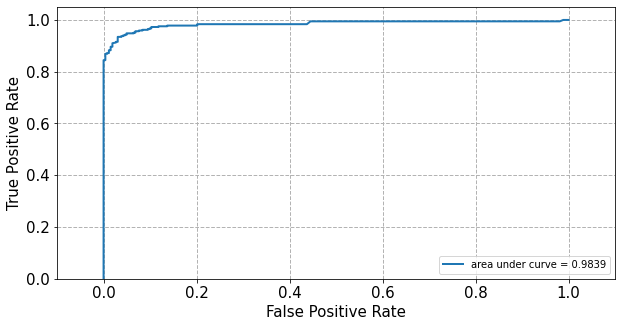

In [ ]:
gnb = GaussianNB()

pipeline_gnb = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=50, n_iter=7, random_state=42)),
    ('gnb', gnb),
])

# ROC curve for gnb

fit_predict_and_plot_roc(pipeline_gnb, X_train_tfidf, X_train_binrary_label, X_test_tfidf, X_test_binrary_label)

#confusion matrix

confusion_matrix = metrics.confusion_matrix(X_test_binrary_label, gnb.predict(X_test_svd))

#accuracy

accuracy=metrics.accuracy_score(X_test_binrary_label, gnb.predict(X_test_svd))

#recall
recall=metrics.recall_score(X_test_binrary_label, gnb.predict(X_test_svd))

#precision
precision=metrics.precision_score(X_test_binrary_label, gnb.predict(X_test_svd))

#f1 score
f_1=metrics.f1_score(X_test_binrary_label, gnb.predict(X_test_svd))


print("Confusion matrix is :\n ", confusion_matrix)

print("Accuracy is : ", accuracy)

print("Recall is : ", recall)

print("Precision is : ", precision)

print("F-1 socre is : ", f_1)

#### **Question 7**
  - The plot and scores for GaussianNB classifier are shown above.
---

#5. Grid Search for hyperparameters

In [ ]:
'''
Loading Data:               cleaning (1)
Construct Vocabulary:       min_df = 3 vs 5 (2)
Feature Extraction:         Stemming vs. Lemmatization (2)
Dimensionality Reduction:   LSI[5, 30, 80] vs. NMF[5, 30, 80] (6)
Classifiers:                SVM(gamma = 10) vs. Logistic Regression[L1 regularization vs. L2 regularization] vs. GaussianNB (4)
'''

ps = nltk.stem.PorterStemmer()
wnl = nltk.wordnet.WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()
# snow_stemmer = SnowballStemmer(language='english')

# train_cleaned = train.applymap(clean)
train_stemmed = stemming(train['full_text'])
train_lemmatized = lemmatize(train['full_text'])

# test_cleaned = test.applymap(clean)
test_stemmed = stemming(test['full_text'])
test_lemmatized = lemmatize(test['full_text'])


In [ ]:
countVectorizer = CountVectorizer(stop_words='english', analyzer='word')
tfidf = TfidfTransformer()

# define 2 dimentionality reduction
svd = TruncatedSVD(random_state=42, n_iter=7)
nmf = NMF(init='random', random_state=42, max_iter=300)

# define 4 classifiers
svm = SVC(C=10, kernel='linear', probability=True)
logistic_L1 = LogisticRegression(C=1000, penalty='l1', solver='liblinear', max_iter=100000)
logistic_L2 =  LogisticRegression(C=100000, penalty='l2', solver='liblinear', max_iter=100000)
gaussian = GaussianNB()

cachedir = mkdtemp()

# define pipeline steps
pipe = Pipeline(steps=[("vect", countVectorizer),
                       ("tfidf", tfidf),
                       ("reduce_dim", "passthrough"),
                       ("classifier", "passthrough")],
                memory=cachedir)

# define pipeline parameters
parameters = {
    "vect__min_df": [3, 5],
    "reduce_dim": [svd, nmf],
    "reduce_dim__n_components": [5, 30, 80],
    "classifier": [svm, logistic_L1, logistic_L2, gaussian]
}


In [ ]:
# run grid search
grid_lemmatized = GridSearchCV(pipe, param_grid=parameters, n_jobs=4, cv=5, scoring='accuracy')
grid_lemmatized.fit(train_lemmatized, X_train_binrary_label)

grid_stemmed = GridSearchCV(pipe, param_grid=parameters, n_jobs=4, cv=5, scoring='accuracy')
grid_stemmed.fit(train_stemmed, X_train_binrary_label)

rmtree(cachedir)

In [ ]:
display(grid_stemmed.best_params_)
display(grid_lemmatized.best_params_)

{'classifier': SVC(C=10, kernel='linear', probability=True),
 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7, random_state=42),
 'reduce_dim__n_components': 80,
 'vect__min_df': 5}

{'classifier': SVC(C=10, kernel='linear', probability=True),
 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7, random_state=42),
 'reduce_dim__n_components': 80,
 'vect__min_df': 5}

In [ ]:
display(grid_stemmed.best_score_)
display(grid_lemmatized.best_score_)

grid_stemmed_results = pd.DataFrame(grid_stemmed.cv_results_)
grid_lemmatized_results = pd.DataFrame(grid_lemmatized.cv_results_)
grid_stemmed_results['Data Process'] = 'stem'
grid_lemmatized_results['Data Process'] = 'lemmatize'

frames = [grid_stemmed_results, grid_lemmatized_results]
  
results = pd.concat(frames)

results.sort_values(by='rank_test_score', inplace=True)

for i in range(5):
  print(results.iloc[i]['rank_test_score'], results.iloc[i]['Data Process'], results.iloc[i]['params'])

0.9595238095238094

0.9591269841269842

1 lemmatize {'classifier': SVC(C=10, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7, random_state=42), 'reduce_dim__n_components': 80, 'vect__min_df': 5}
1 stem {'classifier': SVC(C=10, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7, random_state=42), 'reduce_dim__n_components': 80, 'vect__min_df': 5}
2 stem {'classifier': SVC(C=10, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7, random_state=42), 'reduce_dim__n_components': 80, 'vect__min_df': 3}
2 lemmatize {'classifier': LogisticRegression(C=1000, max_iter=100000, penalty='l1', solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7, random_state=42), 'reduce_dim__n_components': 80, 'vect__min_df': 3}
3 stem {'classifier': LogisticRegression(C=100000, max_iter=100000, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7, random_state=42), 'reduce_dim__n_components': 80, 

In [ ]:
pipelines = []

pipelines.append([train_stemmed, test_stemmed, Pipeline(steps=[("vect", CountVectorizer(min_df=3, stop_words='english', analyzer='word')),
                       ("tfidf", TfidfTransformer()),
                       ("reduce_dim", TruncatedSVD(n_components=5, n_iter=7, random_state=42)),
                       ("classifier", GaussianNB())])])

pipelines.append([train_lemmatized, test_lemmatized, Pipeline(steps=[("vect", CountVectorizer(min_df=3, stop_words='english', analyzer='word')),
                       ("tfidf", TfidfTransformer()),
                       ("reduce_dim", TruncatedSVD(n_components=5, n_iter=7, random_state=42)),
                       ("classifier", GaussianNB())])])

pipelines.append([train_lemmatized, test_lemmatized, Pipeline(steps=[("vect", CountVectorizer(min_df=5, stop_words='english', analyzer='word')),
                       ("tfidf", TfidfTransformer()),
                       ("reduce_dim", NMF(init='random', n_components=5, max_iter=300, random_state=42)),
                       ("classifier", GaussianNB())])])

pipelines.append([train_stemmed, test_stemmed, Pipeline(steps=[("vect", CountVectorizer(min_df=5, stop_words='english', analyzer='word')),
                       ("tfidf", TfidfTransformer()),
                       ("reduce_dim", TruncatedSVD(n_components=5, n_iter=7, random_state=42)),
                       ("classifier", GaussianNB())])])

pipelines.append([train_lemmatized, test_lemmatized, Pipeline(steps=[("vect", CountVectorizer(min_df=5, stop_words='english', analyzer='word')),
                       ("tfidf", TfidfTransformer()),
                       ("reduce_dim", TruncatedSVD(n_components=5, n_iter=7, random_state=42)),
                       ("classifier", GaussianNB())])])

for params in pipelines:
  train_data = params[0]
  test_data = params[1]
  pipe = params[2]
  # print(pipe)
  pipe.fit(train_data, X_train_binrary_label)
  print(pipe.score(test_data, X_test_binrary_label))

0.9444444444444444
0.9253968253968254
0.9047619047619048
0.9444444444444444
0.9333333333333333


#### **Question 8**
**The 5 Best hyperparamaters Combinations and their performance on test data**

|      | min_df | Compression Module | Dimensionality Reduction | k (n_components) | Classifier | Accuracy Score on Test Data |
| :--: | :----: | :----------------: | :----------------------: | :--------------: | :------------------------------------: | :-------------------------: |
| i | 5 | Lemmatization | LSI | 80 | SVC | 0.9444444444444444 |
| ii | 5 | Stemming | LSI | 80 | SVC | 0.9253968253968254 |
| iii | 3 | Stemming | LSI | 80 | SVC | 0.9047619047619048 |
| iv  | 3 | Lemmatization | LSI | 80 | Logistic Regression with L2 Regulation | 0.9444444444444444 |
| v | 5 | Stemming | LSI | 80 | Logistic Regression with L2 Regulation | 0.9333333333333333 |

---

# Multiclass Classification

In [ ]:
multi_categories = pd.DataFrame(data)["leaf_label"].unique()
multi_categories = ["chess", "cricket", "hockey", "soccer",
"football", " forest fire ", "flood", "earthquake",
"drought"]

# clean, vectorize
mclass_train, mclass_test = train_test_split(data[["full_text","leaf_label"]], test_size=0.2)

mclass_train = mclass_train.applymap(clean)
mclass_test = mclass_test.applymap(clean)

mclass_train['full_text'] = lemmatize(mclass_train['full_text'])
mclass_test['full_text'] = lemmatize(mclass_test['full_text'])

mclass_vectorizer = CountVectorizer(min_df=3, stop_words='english')
mclass_X_train = mclass_vectorizer.fit_transform(mclass_train['full_text'])
mclass_X_test = mclass_vectorizer.transform(mclass_test['full_text'])

mclass_X_train_label= mclass_train["leaf_label"]
mclass_X_test_label = mclass_test["leaf_label"]

# turn label into numbers
for i in range(len(multi_categories)):
    mclass_X_train_label[mclass_X_train_label  == multi_categories[i]] = i
    mclass_X_test_label[mclass_X_test_label  == multi_categories[i]] = i
    
mclass_X_train_label = mclass_X_train_label.astype(int)
mclass_X_test_label = mclass_X_test_label.astype(int)

# tfidf transform, dimention reduce
tfidf = TfidfTransformer()

mclass_X_train_tfidf = tfidf.fit_transform(mclass_X_train).toarray()
mclass_X_test_tfidf = tfidf.transform(mclass_X_test).toarray()

svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
mclass_X_train_svd = svd.fit_transform(mclass_X_train_tfidf)
mclass_X_test_svd = svd.transform(mclass_X_test_tfidf)

Naive Bayes

In [ ]:
gnb = GaussianNB()

clf_NB = gnb.fit(mclass_X_train_svd, mclass_X_train_label)
mclass_pred = clf_NB.predict(mclass_X_test_svd)

print('confusion_matrix is :\n', metrics.confusion_matrix(mclass_X_test_label, mclass_pred))
print('accuracy is :', metrics.accuracy_score(mclass_X_test_label, mclass_pred))
print('recall is :', metrics.recall_score(mclass_X_test_label, mclass_pred, average='macro'))
print('precision is :', metrics.precision_score(mclass_X_test_label, mclass_pred, average='macro'))
print('f1_score is :', metrics.f1_score(mclass_X_test_label, mclass_pred, average='macro'))

confusion_matrix is :
 [[64  1  2  1  1  0  0  2  1]
 [ 3 64  1  0  3  0  0  2  0]
 [ 3  0 60  0  1  0  0  0  2]
 [ 3  1  2  8 45  2  0  2  1]
 [ 3  0  0 15 57  1  0  3  1]
 [ 7  1  4  0  0 45  6  0  6]
 [ 3  0  2  1  0  3 69  1  3]
 [ 5  0  3  0  1  0  2 51  1]
 [ 3  0  1  1  0  1 12  4 39]]
accuracy is : 0.7253968253968254
recall is : 0.7171886140270486
precision is : 0.7132275723328348
f1_score is : 0.7051721893601062


SVC OneVsOne

In [ ]:
clf_OneVsOne = OneVsOneClassifier(SVC(random_state=42)).fit(mclass_X_train_svd, mclass_X_train_label)

mclass_pred = clf_OneVsOne.predict(mclass_X_test_svd)

print('confusion_matrix is :\n', metrics.confusion_matrix(mclass_X_test_label, mclass_pred))
print('accuracy is :', metrics.accuracy_score(mclass_X_test_label, mclass_pred))
print('recall is :', metrics.recall_score(mclass_X_test_label, mclass_pred, average='macro'))
print('precision is :', metrics.precision_score(mclass_X_test_label, mclass_pred, average='macro'))
print('f1_score is :', metrics.f1_score(mclass_X_test_label, mclass_pred, average='macro'))

confusion_matrix:
 [[62  0  1  0  0  3  0  0  0]
 [ 0 57  0  0  1  1  0  0  0]
 [ 2  0 70  0  0  8  0  1  0]
 [ 0  0  0 28 48  3  0  0  0]
 [ 1  0  0 33 30  3  0  0  0]
 [ 3  1  0  0  0 56  0  0  4]
 [ 0  0  0  0  1  3 77  5  1]
 [ 3  0  0  0  0  6  0 49  0]
 [ 0  0  0  0  0  5  1  0 63]]
accuracy: 0.780952380952381
recall: 0.7877570305202456
precision: 0.7907614162663613
f1_score: 0.7850916072507614


SVC OneVsRest

In [ ]:
clf_OneVsRest = OneVsRestClassifier(SVC(random_state=42)).fit(mclass_X_train_svd, mclass_X_train_label)

mclass_pred = clf_OneVsRest.predict(mclass_X_test_svd)

print('confusion_matrix is :\n', metrics.confusion_matrix(mclass_X_test_label, mclass_pred))
print('accuracy is :', metrics.accuracy_score(mclass_X_test_label, mclass_pred))
print('recall is :', metrics.recall_score(mclass_X_test_label, mclass_pred, average='macro'))
print('precision is :', metrics.precision_score(mclass_X_test_label, mclass_pred, average='macro'))
print('f1_score is :', metrics.f1_score(mclass_X_test_label, mclass_pred, average='macro'))

confusion_matrix:
 [[62  0  1  0  2  1  0  0  0]
 [ 0 58  0  0  1  0  0  0  0]
 [ 0  0 75  0  1  4  0  1  0]
 [ 0  0  1 26 50  2  0  0  0]
 [ 0  0  1 36 28  1  0  1  0]
 [ 4  1  1  0  1 52  0  1  4]
 [ 0  0  0  0  1  2 78  4  2]
 [ 2  0  0  0  1  1  0 54  0]
 [ 0  0  0  0  0  3  1  0 65]]
accuracy: 0.7904761904761904
recall: 0.7975011418881242
precision: 0.7965454071977383
f1_score: 0.7954480945094211


SVC OneVsOne with Subset

In [ ]:
mclass_X_train_label_withSubset = mclass_X_train_label
mclass_X_test_label_withSubset = mclass_X_test_label

# merge label 'soccer' and 'football'.
for i in range(len(multi_categories)):
    mclass_X_train_label_withSubset[mclass_X_train_label_withSubset  == 4] = 3
    mclass_X_test_label_withSubset[mclass_X_test_label_withSubset  == 4] = 3
    
mclass_X_train_label_withSubset = mclass_X_train_label_withSubset.astype(int)
mclass_X_test_label_withSubset = mclass_X_test_label_withSubset.astype(int)

clf_OneVsOne_withSubset = OneVsOneClassifier(SVC(random_state=42)).fit(mclass_X_train_svd, mclass_X_train_label_withSubset)

mclass_pred = clf_OneVsOne_withSubset.predict(mclass_X_test_svd)

print('confusion_matrix is :\n', metrics.confusion_matrix(mclass_X_test_label_withSubset, mclass_pred))
print('accuracy is :', metrics.accuracy_score(mclass_X_test_label_withSubset, mclass_pred))
print('recall is :', metrics.recall_score(mclass_X_test_label_withSubset, mclass_pred, average='macro'))
print('precision is :', metrics.precision_score(mclass_X_test_label_withSubset, mclass_pred, average='macro'))
print('f1_score is :', metrics.f1_score(mclass_X_test_label_withSubset, mclass_pred, average='macro'))

confusion_matrix:
 [[ 62   0   1   0   3   0   0   0]
 [  0  57   0   1   1   0   0   0]
 [  2   0  70   0   8   0   1   0]
 [  1   0   0 140   5   0   0   0]
 [  3   1   0   0  56   0   0   4]
 [  0   0   0   1   3  77   5   1]
 [  3   0   0   0   6   0  49   0]
 [  0   0   0   0   5   1   0  63]]
accuracy: 0.9111111111111111
recall: 0.9058157263118207
precision: 0.9095082963085348
f1_score: 0.9043453964018038


SVC OneVsRest with Subset

In [ ]:
clf_OneVsRest_withSubset = OneVsRestClassifier(SVC(random_state=42)).fit(mclass_X_train_svd, mclass_X_train_label_withSubset)

mclass_pred = clf_OneVsRest_withSubset.predict(mclass_X_test_svd)

print('confusion_matrix is :\n', metrics.confusion_matrix(mclass_X_test_label_withSubset, mclass_pred))
print('accuracy is :', metrics.accuracy_score(mclass_X_test_label_withSubset, mclass_pred))
print('recall is :', metrics.recall_score(mclass_X_test_label_withSubset, mclass_pred, average='macro'))
print('precision is :', metrics.precision_score(mclass_X_test_label_withSubset, mclass_pred, average='macro'))
print('f1_score is :', metrics.f1_score(mclass_X_test_label_withSubset, mclass_pred, average='macro'))

confusion_matrix:
 [[ 62   0   1   0   1   0   0   2]
 [  0  58   0   1   0   0   0   0]
 [  0   0  74   1   4   0   1   1]
 [  0   0   1 141   3   0   1   0]
 [  4   1   1   0  53   0   1   4]
 [  0   0   0   1   2  78   4   2]
 [  2   0   0   0   1   0  54   1]
 [  0   0   0   0   3   1   0  65]]
accuracy: 0.9285714285714286
recall: 0.9249398313533099
precision: 0.9206650372028651
f1_score: 0.9221008475156098


SVC OneVsOne Balanced

In [ ]:
clf_OneVsOne_balanced = OneVsOneClassifier(SVC(random_state=42, class_weight = 'balanced')).fit(mclass_X_train_svd, mclass_X_train_label)

mclass_pred = clf_OneVsOne_balanced.predict(mclass_X_test_svd)

print('confusion_matrix is :\n', metrics.confusion_matrix(mclass_X_test_label, mclass_pred))
print('accuracy is :', metrics.accuracy_score(mclass_X_test_label, mclass_pred))
print('recall is :', metrics.recall_score(mclass_X_test_label, mclass_pred, average='macro'))
print('precision is :', metrics.precision_score(mclass_X_test_label, mclass_pred, average='macro'))
print('f1_score is :', metrics.f1_score(mclass_X_test_label, mclass_pred, average='macro'))

confusion_matrix:
 [[ 62   0   3   0   1   0   0   0]
 [  0  57   0   1   1   0   0   0]
 [  2   0  71   0   7   0   1   0]
 [  1   1   0 138   6   0   0   0]
 [  3   1   0   0  56   0   0   4]
 [  0   0   0   1   3  77   5   1]
 [  4   0   1   0   4   0  49   0]
 [  0   0   0   0   5   1   0  63]]
accuracy: 0.9095238095238095
recall: 0.9056466074212407
precision: 0.9048564649889892
f1_score: 0.9027683195559535


SVC OneVsRest Balanced

In [ ]:
clf_OneVsRest_balanced = OneVsRestClassifier(SVC(random_state=42, class_weight = 'balanced')).fit(mclass_X_train_svd, mclass_X_train_label)

mclass_pred = clf_OneVsRest_balanced.predict(mclass_X_test_svd)

print('confusion_matrix is :\n', metrics.confusion_matrix(mclass_X_test_label, mclass_pred))
print('accuracy is :', metrics.accuracy_score(mclass_X_test_label, mclass_pred))
print('recall is :', metrics.recall_score(mclass_X_test_label, mclass_pred, average='macro'))
print('precision is :', metrics.precision_score(mclass_X_test_label, mclass_pred, average='macro'))
print('f1_score is :', metrics.f1_score(mclass_X_test_label, mclass_pred, average='macro'))

confusion_matrix:
 [[ 63   0   0   0   1   0   2   0]
 [  0  58   0   1   0   0   0   0]
 [  1   0  71   0   4   0   1   4]
 [  1   0   1 141   0   0   0   3]
 [  3   0   0   0  55   0   1   5]
 [  0   0   0   1   2  78   3   3]
 [  3   0   0   0   4   0  51   0]
 [  0   0   0   0   3   1   0  65]]
accuracy: 0.9238095238095239
recall: 0.9196448738762404
precision: 0.9169628258802396
f1_score: 0.9167080517684851


#### **Question 9**
  - Imbalance issue is resolved through setting the class_weight in sklearn function.
  - Multiclass Classification Confusion Matrix:
    - As the graph shown above, we can see there are distinct visible blocks on the
major diagonal for all of the Naive Bayes, SVC oneVsone and oneVSrest. This means that the prediction has high accuracy.
  - Merged Labels:
    - From the confusion matrix in previous part, we see that the labels 'football' and 'soccer' are easily confused by the model.
As a result, these two labels are merged together and retrained. As shown in the graphs in SVC oneVSone and oneVSrest, the accuracy increases as we merged the labels.
  - Balanced:
    - The imbalance issue is solved in this part. However, as shown in the graphs in SVC oneVSone and oneVSrest, the accuracy changed slightly. As a result, for this data, the imbalance does not impact the performance a lot. 

---

# GLoVE


In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!apt install unzip
!unzip "glove.6B.zip"

In [ ]:
# path = "proj1_classification.csv"

# data = pd.read_csv(path)


train_glove, test_glove = train_test_split(data[["full_text","root_label"]], test_size=0.2)



X_train_binrary_label = train_glove["root_label"]
X_test_binrary_label = test_glove["root_label"]

X_train_binrary_label[X_train_binrary_label  == 'sports'] = 1
X_train_binrary_label[X_train_binrary_label  == 'climate'] = 0
X_train_binrary_label= X_train_binrary_label.astype(int)

X_test_binrary_label[X_test_binrary_label  == 'sports'] = 1
X_test_binrary_label[X_test_binrary_label  == 'climate'] = 0
X_test_binrary_label = X_test_binrary_label.astype(int)

  

In [ ]:
train_glove = lemmatize(train_glove["full_text"].apply(clean))
test_glove = lemmatize(test_glove["full_text"].apply(clean))    

In [ ]:
def glove_conv(text):
    
    v = []

    word_list = word_tokenize(text)
    
    for i in word_list:
        if i in embeddings_dict:
            v.append(embeddings_dict[i])
            
    if not v:
        return None
    
    v = np.stack(v)
    
    norm_factor = np.linalg.norm(v, axis=1, keepdims=True)
    
    v = v / norm_factor
    
    v_avg = np.mean(v, axis=0)
    
    return v_avg


In [ ]:
# find values for queen, king, wife, husband

# The following code block is adppoted from Project-1 manual.

#####################

embeddings_dict = {}
dimension_of_glove = 300

with open("glove.6B.300d.txt", 'r') as f: 

  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

#####################
queen = glove_conv("queen")

king = glove_conv("king")

wife = glove_conv("wife")

husband = glove_conv("husband")


In [ ]:
d1 = np.linalg.norm(queen-king+husband-wife)

d2 = np.linalg.norm(queen-king)

d3 = np.linalg.norm(husband-wife)

print(d1)

print(d2)

print(d3)

0.90996647
0.8559826
0.52030945


#### **Question 10**
  - Ratio of co-occurrence probabilities:
    - (a) GLoVE uses the ratio of co-occurrence probabilities to measure the rarity of two words occurring simultaneously, known as the co-occurrence.  Therefore, words similar to each, such as “good” and “better,” will have closer vectors. This way, the co-occurrence probabilities ratio is a good representation of syntactic and semantic relationships between words. The model can learn the relative importance of different words instead of the absolute frequencies of co-occurrences in a different context. This model captures the meaning of words with effective word embeddings.
  - Vector Difference:
    - (b) GLoVE will not return the same vector in those two sentences. As discussed, GLoVE embeddings have a dependence on the syntactic level. For example, it has a “window” to read the words next to the “running.” In the first sentence, “running” is followed by “in the park,” while “running” in the second sentence is followed by “ for the presidency.” Their vectors will not be the same due to different syntactic features.
  - Expected value for (c):
    - || GLoVE ["queen"] - GLoVE ["king"] - GLoVE ["wife"] + GLoVE ["husband"] ||
  $_2$ should be the largest because the GLoVE model has to calculate the distance between the four words. Although “king” is similar to “queen” in some ways but “king” is  quite different from “wife”. As a result, it indeed has the largest value of 0.90996647.

    - || GLoVE ["queen"] - GLoVE ["king"] || $_2$ should have a relatively small value because "queen" and "king" are similar word, and often occurs together in the context. As a result, it has the second-largest value of 0.8559826.

    - || GLoVE ["wife"] + GLoVE ["husband"] || $_2$ also should have a relatively small value because "wife" and "husband" are similar word, and often occurs together in the context. Furthermore, from my perspective, it may have the smallest value because those two words occur together frequently in the stories that I have read. As a result, it indeed has the smallest value of 0.52030945.
  - Stem vs Lemmatize in GLoVE:
    - (d) I would rather use the lemmatizing method before mapping to the GLoVE embedding. Lemmatization reduces the words to their base form, for example, “am/is/are” to “be.” Therefore,  lemmatization reserves the meaning of words. Furthermore, lemmatization considers the position of the words, such as the `POS_tag` feature. It can preserve the word's sentiment, which is suitable for mapping the GLoVE embedding.

---

In [ ]:

embeddings_dict = {}
dimension_of_glove = 300

with open("glove.6B.300d.txt", 'r') as f: 

  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

X_train_glove =[]
for i in range(len(train_glove)):
  text = train_glove[i]
  X_train_glove.append(glove_conv(text))

X_test_glove = []
for i in range(len(test_glove)):
  text = test_glove[i]
  X_test_glove.append(glove_conv(text))
  

svm = SVC(C=10, kernel='linear', probability=True)

svm.fit(X_train_glove, X_train_binrary_label)

#confusion matrix

confusion_matrix = metrics.confusion_matrix(X_test_binrary_label, svm.predict(X_test_glove))

#accuracy

accuracy=metrics.accuracy_score(X_test_binrary_label, svm.predict(X_test_glove))

acc300 = accuracy

#recall
recall=metrics.recall_score(X_test_binrary_label, svm.predict(X_test_glove))

#precision
precision=metrics.precision_score(X_test_binrary_label, svm.predict(X_test_glove))

#f1 score
f_1=metrics.f1_score(X_test_binrary_label, svm.predict(X_test_glove))


print("Confusion matrix is :\n ", confusion_matrix)

print("Accuracy is : ", accuracy)

print("Recall is : ", recall)

print("Precision is : ", precision)


print("F-1 socre is : ", f_1)

Confusion matrix is :
  [[297  13]
 [ 13 307]]
Accuracy is :  0.9587301587301588
Recall is :  0.959375
Precision is :  0.959375
F-1 socre is :  0.959375


In [ ]:
# try keywords extractions 

train_glove_key, test_glove_key = train_test_split(data[["keywords","root_label"]], test_size=0.2)

train_glove_key = lemmatize(train_glove_key["keywords"].apply(clean))
test_glove_key = lemmatize(test_glove_key["keywords"].apply(clean))    

embeddings_dict = {}
dimension_of_glove = 300

with open("glove.6B.300d.txt", 'r') as f: 

  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector




X_train_glove =[]
for i in range(len(train_glove_key)):
  text = train_glove_key[i]
  X_train_glove.append(glove_conv(text))

X_test_glove = []
for i in range(len(test_glove_key)):
  text = test_glove_key[i]
  X_test_glove.append(glove_conv(text))



svm.fit(X_train_glove, X_train_binrary_label)

#confusion matrix

confusion_matrix = metrics.confusion_matrix(X_test_binrary_label, svm.predict(X_test_glove))

#accuracy

accuracy=metrics.accuracy_score(X_test_binrary_label, svm.predict(X_test_glove))

#recall
recall=metrics.recall_score(X_test_binrary_label, svm.predict(X_test_glove))

#precision
precision=metrics.precision_score(X_test_binrary_label, svm.predict(X_test_glove))

#f1 score
f_1=metrics.f1_score(X_test_binrary_label, svm.predict(X_test_glove))


print("Confusion matrix is :\n ", confusion_matrix)

print("Accuracy is : ", accuracy)

print("Recall is : ", recall)

print("Precision is : ", precision)


print("F-1 socre is : ", f_1)

Confusion matrix is :
  [[ 74 236]
 [ 56 264]]
Accuracy is :  0.5365079365079365
Recall is :  0.825
Precision is :  0.528
F-1 socre is :  0.6439024390243903


#### **Question 11**
  - (a) Feature engineering process:
    - In the extracting process, the text is cleaned and lemmatized by the function:  `clean()` and `lemmatize()`. 
    - The function `glove_conv` processes the representation of the text. In this function, it reads sentences, breaks them into words, and compares them with the dictionary created by glove.6B.300d.txt. If the words are in the dictionary, the words will be represented by the matrices in the txt file. Words will be aggregated into a single vector by normalizing and averaging vectors by np.linalg.norm(). It is worth noting that the parameter `keepdims` is set to True to keep the dimension. 
    - Features `“full_text”` and `“keywords”` are both trained to compare. However, using `“keywords”` as feature results in low accuracy. This is expected because `“keywords”` offers very limited information regarding the classification compared to the `“full_text.”`
  - (b) Classifier Model:
    - SVM classifier model is chosen (c =10) to train and evaluate it with the GLoVE-based feature
---

* Relationship between the dimension of the pre-trained GLoVE

In [ ]:
embeddings_dict = {}
dimension_of_glove = 50



with open("glove.6B.50d.txt", 'r') as f: 

  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

X_train_glove =[]
for i in range(len(train_glove)):
  text = train_glove[i]
  X_train_glove.append(glove_conv(text))

X_test_glove = []
for i in range(len(test_glove)):
  text = test_glove[i]
  X_test_glove.append(glove_conv(text))

svm = SVC(C=10, kernel='linear', probability=True)

svm.fit(X_train_glove, X_train_binrary_label)

accuracy=metrics.accuracy_score(X_test_binrary_label, svm.predict(X_test_glove))

acc50=accuracy

print("Accuracy for 50-Dim is : ", accuracy)

#################################################



embeddings_dict = {}
dimension_of_glove = 100



with open("glove.6B.100d.txt", 'r') as f: 

  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

X_train_glove =[]
for i in range(len(train_glove)):
  text = train_glove[i]
  X_train_glove.append(glove_conv(text))

X_test_glove = []
for i in range(len(test_glove)):
  text = test_glove[i]
  X_test_glove.append(glove_conv(text))



svm.fit(X_train_glove, X_train_binrary_label)

accuracy=metrics.accuracy_score(X_test_binrary_label, svm.predict(X_test_glove))

acc100=accuracy

print("Accuracy for 100-Dim is : ", accuracy)

#################################################

embeddings_dict = {}
dimension_of_glove = 200



with open("glove.6B.200d.txt", 'r') as f: 

  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

X_train_glove =[]
for i in range(len(train_glove)):
  text = train_glove[i]
  X_train_glove.append(glove_conv(text))

X_test_glove = []
for i in range(len(test_glove)):
  text = test_glove[i]
  X_test_glove.append(glove_conv(text))



svm.fit(X_train_glove, X_train_binrary_label)

accuracy=metrics.accuracy_score(X_test_binrary_label, svm.predict(X_test_glove))

acc200=accuracy

print("Accuracy for 200-Dim is : ", accuracy)
print("Accuracy for 300-Dim is : ", acc300)

Accuracy for 50-Dim is :  0.9396825396825397
Accuracy for 100-Dim is :  0.9523809523809523
Accuracy for 200-Dim is :  0.9587301587301588
Accuracy for 300-Dim is :  0.9587301587301588


Text(0, 0.5, 'Accuracy')

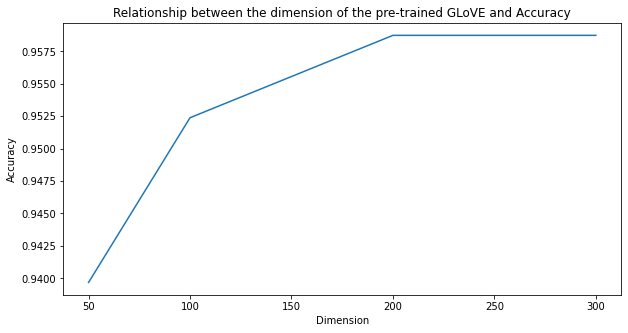

In [ ]:
#Acc=[0.9428571428571428, 0.953968253968254, 0.9476190476190476, 0.946031746031746 ]
Acc=[acc50, acc100, acc200, acc300]
D=[50, 100, 200, 300]



plt.plot(D, Acc)

plt.title('Relationship between the dimension of the pre-trained GLoVE and Accuracy')
plt.xlabel('Dimension')
plt.ylabel('Accuracy')


#### **Question 12**
  - Dimensions vs Accuaracy:
    - The plot of the relationship between the dimension of the pre-trained GLoVE embedding is shown above. However, the plot slightly varies in each run due to the randomness in the `train_test_split` process. The general trend shows that the accuracy increases and then saturates/decreases. This trend is expected because low dimensions provide limited information and how dimensions will cause overfitting. Therefore, it is reasonable to predict that the optimal dimension is in between. 
---

* UMAP

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

In [ ]:
import umap
import umap.plot

Text(0.5, 1.0, 'normalized random vectors of the same dimension as GLoVE')

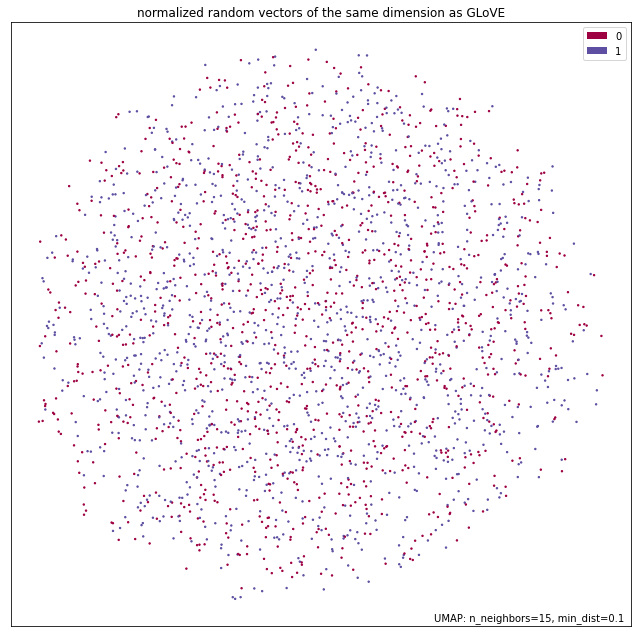

In [ ]:
# normalized random vectors of the same dimension

# The following code block is adppoted from Project-1 manual.

######################
randm_points = np.random.randn(2520, 300)

randm_points = randm_points / np.linalg.norm(randm_points) 

reducer = umap.UMAP(n_components = 2, random_state =42 )

reducer.fit(randm_points)

label = np.array ([random.randint(0,1) for _ in range (2520)])
umap.plot.points(reducer, label)

######################

plt.title("Normalized random vectors of the same dimension as GLoVE")

Text(0.5, 1.0, 'vectors of GLoVE with dimension = 300')

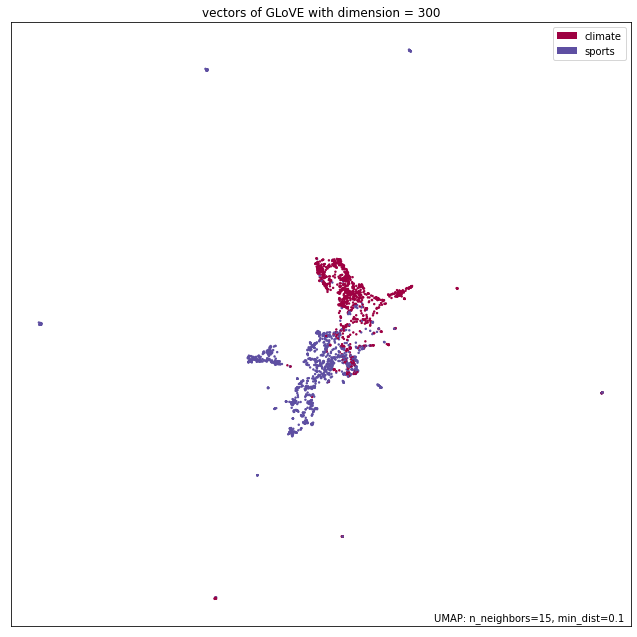

In [ ]:
embeddings_dict = {}
dimension_of_glove = 300

with open("glove.6B.300d.txt", 'r') as f: 

  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

X_train_glove =[]
for i in range(len(train_glove)):
  text = train_glove[i]
  X_train_glove.append(glove_conv(text))

X_test_glove = []
for i in range(len(test_glove)):
  text = test_glove[i]
  X_test_glove.append(glove_conv(text))

reducer = umap.UMAP(n_components = 2, random_state =42 )
reducer.fit(X_train_glove)

label=[]
for i in X_train_binrary_label:
  if i ==1:
    label.append("sports")
  else:
    label.append("climate")

label = np.array (label)
umap.plot.points(reducer, label)

plt.title("vectors of GLoVE with dimension = 300")

#### **Question 13**
  - Clustering:
    - As shown in the figures, there is a clustering in GLoVE-based embeddings, but not in the randomized vectors.
---

In [ ]:

!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('ECE219_Project01_Classification.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern '$notebookpath$file_name' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y

'File Download Unsuccessful. Saved in Google Drive'